# Policy Gradient Methods for Reinforcement Learning with Function Approximation

In [ ]:
%load_ext autoreload
%autoreload 2
import gym
import time
import threading
from pprint import pprint
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

#%matplotlib widget
mpl.style.use('dark_background')
tf.enable_eager_execution()
plotly.offline.init_notebook_mode(connected=True)

# Introduction

- For the decade preceding this paper (and still for some time after), the *value-based* approach dominated reinforcement learning.
- This approach worked by estimating a value function and following a "greedy" policy, which is selecting an action leading to the highest possible reward
- Value-based methods have limitations, though:
    - It is oriented towards deterministic policies, whereas the optimal policy is often stochastic
    - An arbitrarily small change in the estimated value of an action can cause it to be, or not be selected, causing issues with establishing convergence assurances  
- Examples of such methods include Q-learning, Sarsa, and dynamic programming methods.

In this paper, the authors explore an alternative approach to function approximation in RL.

# Policy Gradient Approach

- Rather than approximate a value function and using that to compute a deterministic policy, we approximate a stochastic policy directly
- The policy can be represented as a neural network whose input is a representation of the state, whose output is action selection probabilities, and whose weights are policy parameters

Let $\theta$ denote the vector of policy parameters and $\rho$ the performance of the corresponding policy (e.g., the average reward per step).  Then, in the *policy gradient* approach, the policy parameters are updated approximately proportional to the gradient:

$$\nabla\theta \approx \alpha\frac{\partial\rho}{\partial\theta}\tag{1}$$

where $\alpha$ is a positive-definite step size.  If this can be achieved, then $\theta$ can usually be assured to converge to a locally optimal policy in the performance measure $\rho$.

## Markov Decision Process

- state, action, and reward at each time $t \in \{0, 1, 2, ...\}$ are denoted $s_t \in S$, $a_t \in A$, and $r_t \in \mathbb{R}$
- the environment's dynamics are characterized by state transition probabilities, $P^a_{ss'} = Pr\{ s_{t+1} = s' \mid s_t = s, a_t = a\}$ and expected rewards $R^a_s = \mathbb{E}\{r_{t+1} \mid s_t = s, a_t = a\}, \forall s, s' \in S, a\in A$
- the agent's decision making procedure is characterized by a policy, $\pi(s,a,\theta) = Pr\{a_t=a \mid s_t=s,\theta\}, \forall s\in S, a\in A$, where $\theta \in \mathbb{R}^l$, for $l << \left| S \right|$, is a parameter vector.  We'll often just write $\pi(s,a,\theta)$ as $\pi(s,a)$.
- we assume $\pi$ is differentiable with respect to its parameter, i.e., that $\frac{\partial\pi(s,a)}{\partial\theta}$ exists.

## Start-State Formulation

$$ \rho(\pi) = \mathbb{E}\{ \sum_{t=1}^{\infty} \gamma^{t-1}r_t \mid s_0,\pi\} $$

$$ Q^\pi(s,a) = \mathbb{E}\{ \sum_{k=1}^{\infty} \gamma^{k-1}r_{t+k} \mid s_t = s, a_t = a, \pi \} $$

where $\gamma \in [0,1]$ is a discount rate.

We define $d^\pi (s)$ as a discounted weighting of states encountered starting at $s_0$ and the following $\pi$:

$$ d^\pi(s) = \sum_{t=0}^{\infty} \gamma^t Pr\{s_t=s \mid s_0,\pi\}$$

#### **Theorem 1 (Policy Gradient)**

For any MDP,

$$
\frac{\partial \rho}{\partial \theta}
= \sum_s d^\pi (s)
\sum_a \frac{\partial \pi(s,a)}{\partial \theta} Q^\pi(s,a)
\tag{2}
$$

In words, this says the gradient of $\rho$, the performance of our policy, with respect to $\theta$, the parameters of our policy, is the sum of products of the gradient of our policy, $\pi$, with respect to $\theta$ and $Q^\pi$, our value at the given state, for every possible action, multiplied by a weighing $d^\pi$ summed over every possible state.

Basically, if we can approximate $Q^\pi$ given such a policy $\pi$, then we can calculate the gradient of $\rho$ to maximize the performance of our policy.

## Policy Gradient with Approximation

If we can approximate $Q^\pi$ by a learned function, we can use it in place of $Q^pi$ in the above theorem and still point roughly in the direction of the gradient.

Let $f_w : S \times A \rightarrow \mathbb{R}$ be our approximation to $Q^\pi$ with parameter $w$.  It is natural to learn $f_w$ by following $\pi$ and updating $w$ by a rule such as

$$ \Delta w_t 
\; \propto \;
\frac{\partial}{\partial w}[\hat{Q}^\pi(s_t, a_t) - f_w (s_t, a_t)]^2 
\; \propto \;
[ \hat{Q}^\pi (s_t, a_t) - f_w(s_t, a_t)] \frac{\partial f_w (s_t, a_t)}{\partial w} $$

where $\hat{Q}^\pi$ is some unbiased estimator of $Q^\pi(s_t,a_t)$, perhaps $R_t$

When such a process has converged to a local optimum, then

$$
\sum_s d^\pi(s) \sum_a \pi(s,a)[Q^\pi (s,a) - f_w(s,a)] \frac{\partial f_w(s,a)}{\partial w} = 0
\tag{3}
$$

#### **Theorem 2 (Policy Gradient with Function Approximation)**

If $f_w$ satisfies (3) and is compatible with the policy parameterization in the sense that

$$
\frac{\partial f_w (s,a)}{\partial w} = \frac{\partial \pi (s,a)}{\partial \theta} \frac{1}{\pi(s,a)}
\tag{3}
$$

then

$$
\frac{\partial \rho}{\partial \theta} = \sum_s d^\pi(s) \sum_a \frac{\partial \pi (s,a)}{\partial \theta} f_w(s,a)
\tag{5}
$$

This is equivalent to our first theorem, except in place of our state-value function $Q^\pi$ we have our learned approximation $f_w$.

## Application to Deriving Algorithms

Given a policy parameterization, Theorem 2 can be used to derive an appropriate form of the value-function parameterization.  Consider a policy that is a Gibbs distribution in a linear combination of features, i.e., softmax:

$$
\pi(s,a) = \frac{e^{\theta^T\phi_{sa}}}{\sum_b e^{\theta^T\phi_{sb}}},
\forall s \in S, a \in A
$$

where each $\phi_{sa}$ is an $l$-dimensional feature vector characterizing state-action pair $s,a$.  Meeting the compatibility condition (4) requires that

$$
\frac{\partial f_w(s,a)}{\partial w} = \frac{\partial \pi (s,a)}{\partial \theta} \frac{1}{\pi(s,a)} = \phi_{sa} - \sum_b \pi(s,b)\phi_{sb}
$$

so that the natural parameterization of $f_w$ is

$$
f_w(s,a) = w^T[\phi_{sa} - \sum_b \pi(s,b) \phi_{sb} ]
$$

[0.3790582]
[0.33911682]
[0.28182499]
Sum: 0.9999999999999999


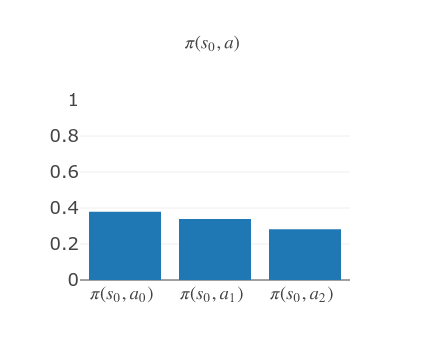

In [2]:
theta = np.random.normal(0.5, 0.1, (6, 1))
phi = lambda s, a: np.concatenate((s, a))

states = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]

actions = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]

def pi(s, a):
    num = np.exp(np.dot(theta.T, phi(s, a)))
    den = np.sum([np.exp(np.dot(theta.T, phi(s, b))) for b in actions])
    return num/den

results = []
for a in actions:
    result = pi(states[0], a)
    print(result)
    results.append(result)

print('Sum:', np.sum(results))

data = go.Bar(
    x=[f'$\pi(s_0, a_{i})$' for i, a in enumerate(actions)],
    y=np.array(results).squeeze()
)

layout = go.Layout(
    title='$$\pi(s_0, a)$$',
    template='presentation',
    yaxis=dict(
        range=[0,1]
    )
)

plotly.offline.iplot({
    "data": [data],
    "layout": layout
})

[-0.07608502]
[0.14092391]
[-0.06723683]
Sum: -0.0023979343857121194
Mean: -0.0007993114619040398


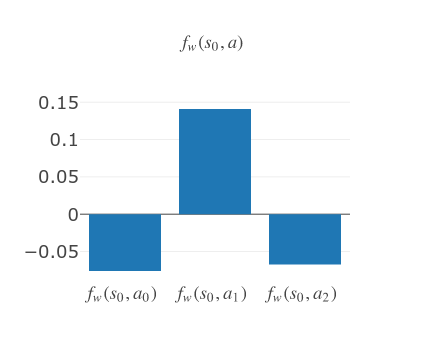

In [3]:
w = np.random.normal(0.5, 0.1, (6, 1))

def f(s, a):
    return np.dot(w.T, phi(s, a)) - np.dot(w.T, np.sum([ pi(s, b) * phi(s, b) for b in actions], axis=0))

results = []
for a in actions:
    result = f(states[0], a)
    print(result)
    results.append(result)
    
print('Sum:', np.sum(results))
print('Mean:', np.mean(results))

data = go.Bar(
    x=[f'$f_w(s_0, a_{i})$' for i, a in enumerate(actions)],
    y=np.array(results).squeeze()
)

layout = go.Layout(
    title='$$f_w(s_0, a)$$',
    template='presentation'
)

plotly.offline.iplot({
    "data": [data],
    "layout": layout
})

## Advantages

The above form of $f_w$ requires that it have zero mean for each state: $\sum_a \pi(s,a) f_w(s,a) = 0, \forall s\in S$.  In this since, it's better to think of $f_w$ as an approximation of the *advantage* function, $A^\pi (s,a) = Q^\pi (s,a) - V^\pi (s)$, rather than of $Q^\pi$.

We can generalize (5) to

$$
\frac{\partial \rho}{\partial \theta} = \sum_s d^\pi(s) \sum_a \frac{\partial \pi (s,a)}{\partial \theta} [f_w(s,a) - v(s)]
$$

where $v: S \rightarrow \mathbb{R}$ is an arbitrary function.  The choice of $v$ doesn't affect any of these theorems, but can affect the variance of the gradient estimators.  In practice, $v$ should be set to the best available approximation of $V^\pi$

#### **Theorem 3 (Policy Iteration with Function Approximation)**

Let $\pi$ and $f_w$ be any differentiable function approximators for the policy and value function respectively that satisfy the compatibility condition (4) and for which

$$
\max_{\theta, s, a, i, j} \left|\frac{\partial^2 \pi(s,a)}{\partial \theta_i \partial \theta_j} \right| < B < \infty
$$

Let ${\alpha_k}_{k=0}^{\infty}$ be any step-size sequence such that $\lim_{k\rightarrow\infty} \alpha_k = 0$ and $\sum_k \alpha_k = \infty$.  Then, for any MDP with bounded rewards, the sequence $\{\rho(\pi_k)\}_{k=0}^{\infty}$, defined by any $\theta_0, \pi_k=\pi(\dot\:,\dot\:,\theta_k)$, and

\begin{align}
& w_{k\;} = w \textrm{ such that } \sum_s d^{\pi k}(s) \sum_a \pi_k (s,a)[Q^{\pi_k}(s,a) - f_w(s,a)]\frac{\partial f_w(s,a)}{\partial w} = 0
\\
& \theta_{k+1} = \theta_k + \alpha_k \sum_s d^{\pi_k}(s) \sum_a \frac{\partial \pi_k (s,a)}{\partial \theta} f_{w_k} (s,a)
\end{align}

converges such that $\lim_{k\rightarrow \infty} \frac{\partial \rho(\pi_k)}{\partial\theta} = 0$

# Experiment

## Updating $\theta$ through $\pi$ and $f_w$

We can now test these theorems using code.  At a high level, what we want to accomplish is:
- Defining our action space $A$ and state space $S$
- Initializing $\theta$ and $w$
- Defining our $\pi$ and $f_w$ functions
- Defining our $\nabla\pi$ and $\nabla f_w$ functions
- Defining our training function, which incorporates the update rule for $\theta$

### $A$ and $S$

First, we need to define our state and action spaces.  In order to easily visualize this procedure, we'll need to keep these spaces simple.  Here, the action space $A$ is discrete and of cardinality 3.  We represent each state as a one-hot encoding.  Similarly, the state space is $S$ is discrete and of cardinality.  We give it a similar treatment.

In [5]:
actions = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

states = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

### $\theta$, $w$, and $\phi$

Next, we initialize $\theta$ and $w$ as arrays of length 6 where each entry is a random value sampled from a normal distribution with mean $0.5$ and variance $0.1$.  We also define $\phi$, our characterization of our state-action pair.  Here, we simply concatenate the two one-hot encodings for the state and action to form $\phi$.

In [6]:
theta = np.random.normal(0.5, 0.1, (len(states) + len(actions), 1))
w = np.random.normal(0.5, 0.1, (6, 1))
phi = lambda s, a: np.concatenate((s, a))

### $\pi$, $\nabla \pi$, $f_w$, and $\nabla f_w$

We next define our policy and value functions, along with their gradient functions.

In [7]:
def f(s, a):
    result = np.dot(w.T, phi(s, a)) - np.dot(w.T, np.sum([ pi(s, b) * phi(s, b) for b in actions], axis=0))
    return result

def f_grad(s, a, r):
    df = phi(s, a) - np.sum([ pi(s, b) * phi(s, b) for b in actions], axis=0)
    result = (r - f(s,a))*df
    return result

def pi(s, a):
    num = np.exp(np.dot(theta.T, phi(s, a)))
    den = np.sum([np.exp(np.dot(theta.T, phi(s, b))) for b in actions])
    return num/den

def pi_grad(s, a):
    left = phi(s, a)*pi(s, a)
    right = np.exp(np.dot(theta.T, phi(s, a))) * np.sum([ phi(s,b)*np.exp(np.dot(theta.T, phi(s, b))) for b in actions])
    diff = left - right
    den = (np.sum([ np.exp(np.dot(theta.T, phi(s, b))) for b in actions ]))**2
    return diff/den

### Training Function

Finally, we define our `update` function to facilitate the policy iteration we'll use for experimentation.  We simply calculate the gradient and add it to $\theta$.

In [8]:
def update(action, state, theta):
    alpha = 1.
    grad = pi_grad(states[state], actions[action]).reshape(theta.shape)
    return alpha*grad*f(states[state], actions[action])

(the rest is for visualization only)

In [21]:
state = 0
verbose = False
def train(action):
    global theta
    iters = 10

    for i in range(iters):
        theta += update(action, state, theta)

    fig.data[0]['y'] = np.array([pi(states[state], a) for a in actions]).flatten()
    
    with out:
        if verbose:
            print(action)

# setup plotting

layout_params = dict(
    title="$\pi(s_0,a)$",
    yaxis=dict(
        range=[0,1]
    ),
    template="plotly_dark+presentation"
)
layout = go.Layout(**layout_params)

data = []
data.append(
    go.Bar(
        x=[f'$\pi(s_0, a_{i})$' for i in range(len(actions))],
        y=np.array([pi(states[state],a) for a in actions]).flatten()
    )
)

fig = go.FigureWidget(data=data, layout=layout)

# value function
results = []
for a in actions:
    result = f(states[0], a)
    results.append(result)

value_data = go.Bar(
    x=[f'$f_w(s_0, a_{i})$' for i, a in enumerate(actions)],
    y=np.array(results).squeeze()
)

value_layout = go.Layout(
    title='$$f_w(s_0, a)$$',
    template='plotly_dark+presentation'
)

value_widget = go.FigureWidget(data=[value_data], layout=value_layout)

out = widgets.Output(layout={'border': '1px solid black'})

# interaction

state_dropdown = widgets.Dropdown(
    options=[f'State {s}' for s in range(3)],
    description='State:',
    layout=widgets.Layout(
        width='25%'
    )
)

def dropdown_change(change):
    global state
    if change['name'] == 'index':
        with out:
            state = change['new']

state_dropdown.observe(dropdown_change)

options_box = widgets.HBox(
    [
        state_dropdown
    ],
    layout=widgets.Layout(
        width='100%',
        justify_content='space-around',
        margin='10px 0'
    )
)

buttons = []
for i, a in enumerate(actions):
    button = widgets.Button(
        description=f'a_{i}',
        state=i
    )
    button_function = lambda state: lambda b: train(state)
    button.on_click(button_function(i))
    buttons.append(button)

button_box = widgets.HBox(
    buttons,
    layout=widgets.Layout(
        width='100%',
        justify_content='space-around',
        margin='10px 0'
    )
)

verbose = False
widgets.VBox([
    widgets.HBox(
        [fig, value_widget],
        layout=widgets.Layout(
            width='100%',
            justify_content='space-around',
            margin='10px 0'
        )
    ),
    button_box,
    out
])

    'data': [{'type': 'bar',
              'uid': '0eb65587-27f2-…

Once the visualization is ran, you should see two bar plots with three buttons labeled "a_0", "a_1", and "a_2" underneath.  The plot on the left represents the probability of selecting either action 0, action 1, or action 2 (respectively) during state 0.  The plot on the right represents the predicted value for each of the actions in this state.  The choice of state 0 is arbitrary.

When you click a button, it will call the `update` function with the button's corresponding action.  In terms of a Markov decision process, it simulates the agent taking the chosen action in the current state.  If you choose an action with a positive estimated reward, $\theta$ will be updated to encourage that action being taken in this state by increasing it's probability.  If the estimated value if negative, then it will be discouraged.

## Defining an Environment

Now that we have the mechanisms in place and tested, we create our proper Markov decision process.

To do so, we define two classes: an Environment and an Agent.

For our environment, we need to define it's transition probabilities $P_{ss'}^a$ and expected rewards $R_s^a$.  For our experiment, we use tables to represent these functions.

To facilitate training, we follow OpenAI's Gym standard for writing environments.  This means that we also write a `step` method which accepts an action as input and returns the next state's observation, reward, and a boolean indicating if the episode is over.  Finally, we add a `reset` method which runs at the beginning of each episode to reset the state.

In [10]:
class Environment:
    def __init__(self):
        self.t_limit = 5 # done after 5 time steps
        self.states = [
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ]
        self.transition_probs = [
            [
                [ 0.1, 0.7, 0.2 ],
                [ 0.1, 0.7, 0.2 ],
                [ 0.1, 0.7, 0.2 ]
            ],
            [
                [ 0.3, 0.3, 0.4 ],
                [ 0.3, 0.3, 0.4 ],
                [ 0.3, 0.3, 0.4 ]
            ],
            [
                [ 0.5, 0.2, 0.3 ],
                [ 0.5, 0.2, 0.3 ],
                [ 0.5, 0.2, 0.3 ]
            ]
        ]
        self.reward_probs = [
            [ -1.0, 1.0, 0.0 ],
            [ 0.0, -1.0, 1.0 ],
            [ 1.0, -1.0, 0.0 ]
        ]
    
    def P(self, s, a):
        return self.transition_probs[s][a]
    
    def R(self, s, a):
        return self.reward_probs[s][a]
    
    def step(self, action):
        next_state = np.random.choice(3, p=self.P(self.current_state, action))
        reward = self.R(self.current_state, action)
        
        self.t += 1
        done = False
        if self.t >= self.t_limit:
            done = True
        
        self.current_state = next_state
        
        return obs, reward, done
    
    def reset(self):
        self.t = 0
        self.current_state = 0
        return self.states[self.current_state]

## Defining an Agent

Next, we define our Agent class which will interact with our Environment class.  Here, we add give the agent it's own `theta` and `w` attributes as well as define it's `pi` method (similar to the previous example) and a `step` method, which accepts an observation from a state and returns an action, with the action being a sampling of $\pi$ given the state and each possible action.  We also include our various update methods from above.

In [11]:
class Agent:
    def __init__(self, obs_size=3):
        self.actions = [
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ]
        self.theta = np.random.normal(0.5, 0.1, (obs_size + len(actions), 1))
        self.w = np.random.normal(0.5, 0.1, (obs_size + len(actions), 1))
        
    def pi(self, s, a):
        num = np.exp(np.dot(self.theta.T, phi(s, a)))
        den = np.sum([np.exp(np.dot(self.theta.T, phi(s, b))) for b in actions])
        return num/den
    
    def step(self, observation):
        probs = np.array([self.pi(observation, action) for action in self.actions]).flatten()
        return np.random.choice(len(probs), p=probs)
    
    def f(self, s, a):
        return np.dot(self.w.T, phi(s, a)) - np.dot(self.w.T, np.sum([ pi(s, b) * phi(s, b) for b in actions], axis=0))

    def f_grad(self, s, a, r):
        df = phi(s, a) - np.sum([ pi(s, b) * phi(s, b) for b in actions], axis=0)
        return (r - self.f(s,a))*df

    def pi(self, s, a):
        num = np.exp(np.dot(self.theta.T, phi(s, a)))
        den = np.sum([np.exp(np.dot(self.theta.T, phi(s, b))) for b in actions])
        return num/den

    def pi_grad(self, s, a):
        left = phi(s, a)*self.pi(s, a)
        right = np.exp(np.dot(self.theta.T, phi(s, a))) * np.sum([ phi(s,b)*np.exp(np.dot(self.theta.T, phi(s, b))) for b in actions])
        diff = left - right
        den = (np.sum([ np.exp(np.dot(self.theta.T, phi(s, b))) for b in actions ]))**2
        return diff/den
    
    def update_theta(self, state, action):
        alpha = 0.1
        grad = self.pi_grad(state, action).reshape(self.theta.shape)
        self.theta = alpha*grad*f(state, action)
        
    def update_w(self, state, action, reward):
        beta = 0.01
        gradients = np.expand_dims(self.f_grad(state, action, reward), axis=0).T
        self.w += beta*gradients
    
    def train(self, data):
        batch_size = len(data['states'])
        for i in range(batch_size):
            s = data['states'][i]
            a = data['actions'][i]
            r = data['rewards'][i]
            self.update_w(s, a, r)
            self.update_theta(s, a)

## Running the MDP

Finally, we can run a single episode of the Markov decision process.  We first initialize an environment and an agent and reset the environment (collecting the initial observation).

While the environment is not done, we pass the observation to the agent's step method, then collect the returned action.  We then pass the returned action to the environment to proceed to the next step.  The loop is finished when `done` is `False` (in this case, after 5 time steps).

In [12]:
env = Environment()
agent = Agent()

done = False
obs = env.reset()

data = {
    'states': [],
    'actions': [],
    'rewards': []
}
while not done:
    action = agent.step(obs)
    print(f"s: {env.current_state}, a: {action}")
    
    obs, reward, done = env.step(action)
    print(f"r: {reward}")
    
    data['states'].append(np.array(obs))
    data['actions'].append(actions[action])
    data['rewards'].append(reward)
    print()
    
print(f"Total Reward: {sum(data['rewards'])}")

s: 0, a: 0
r: -1.0

s: 2, a: 2
r: 0.0

s: 2, a: 2
r: 0.0

s: 0, a: 1
r: 1.0

s: 0, a: 1
r: 1.0

Total Reward: 1.0


## Training

We can now train our agent on this environment.  First, we have to define a function to allow us to train our value approximator $f_w$.  Similarly to our `update` function used to train the policy, we write a `train_value` function to train $f$ by updating $w$.

In [13]:
def update_value(data):
    beta = 0.01
    batch_size = len(data['states'])
    for i in range(batch_size):
        s = data['states'][i]
        a = data['actions'][i]
        r = data['rewards'][i]
        gradients = np.expand_dims(f_grad(s, a, r), axis=0).T
        return beta*gradients

Here is the batch of data we just collected:

In [14]:
pprint(data)

{'actions': [array([1, 0, 0]),
             array([0, 0, 1]),
             array([0, 0, 1]),
             array([0, 1, 0]),
             array([0, 1, 0])],
 'rewards': [-1.0, 0.0, 0.0, 1.0, 1.0],
 'states': [array([1, 0, 0]),
            array([1, 0, 0]),
            array([1, 0, 0]),
            array([1, 0, 0]),
            array([1, 0, 0])]}


And here is what our current $f_w$ predicts the value of some arbitrary state and action is, and here is what it actually turned out to be:

In [15]:
theta = np.random.normal(0.5, 0.1, (len(states) + len(actions), 1))
w = np.random.normal(0.5, 0.1, (6, 1))

f_sample = f(data['states'][0], data['actions'][0])
actual = data['rewards'][0]

print('f(s_k, a_k):', f_sample[0])
print('R(s_k, a_k):', actual)

f(s_k, a_k): -0.14390025791856054
R(s_k, a_k): -1.0


By running this function, we'll train our $f_w$ for one epoch on the data we collected.  After running this, run the above cell again and notice how the predicted value changes.

In [16]:
losses = []
for epoch in range(500):
    w += update_value(data)
    loss = []
    for i in range(len(data['states'])):
        f_sample = f(data['states'][0], data['actions'][0])
        actual = data['rewards'][0]
        loss.append(abs(actual - f_sample))
    losses.append(np.mean(loss))
losses = np.array(losses).flatten()

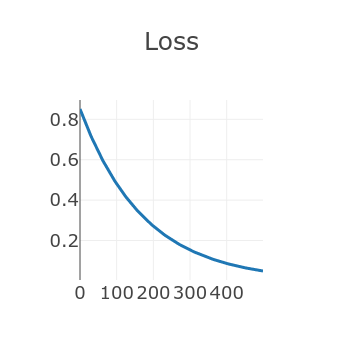

In [18]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(losses)), y=losses)],
    "layout": go.Layout(title="Loss", template="presentation")
})

Finally, we combine everything we have and let it train:

In [19]:
env = Environment()
agent = Agent()

total_rewards = []
episodes = 1000
for ep in range(episodes):
    done = False
    obs = env.reset()

    data = {
        'states': [],
        'actions': [],
        'rewards': []
    }
    while not done:
        action = agent.step(obs)
        obs, reward, done = env.step(action)

        data['states'].append(np.array(obs))
        data['actions'].append(actions[action])
        data['rewards'].append(reward)
    
    agent.train(data)    
    total_rewards.append(sum(data['rewards']))

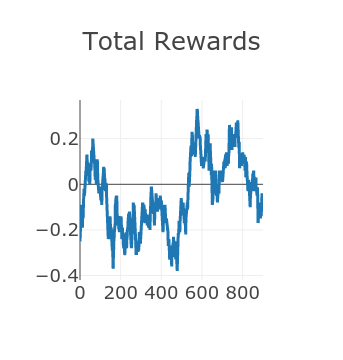

In [20]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(total_rewards)), y=moving_average(total_rewards, 100))],
    "layout": go.Layout(title="Total Rewards", template="presentation")
})